# Anomaly Detection fake access point

**Objectives**: implement Gaussian distribution model to detect rogue access points. 

In [1631]:
# Loading relevant libraries and the dataset
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Load Data 

In [1632]:
normal_beacons = np.loadtxt("home_beacons_obs_features.dat", delimiter=" ", skiprows=1)
abnormal_beacons = np.loadtxt("other_home_beacons_obs_features.dat", delimiter=" ", skiprows=1)

print(f"Total normal beacons examples: {len(normal_beacons)}")
print(f"Total abnormal beacons examples: {len(abnormal_beacons)}")

normal_assoc = np.loadtxt("home_association.csv", delimiter=",", skiprows=1)
abnormal_assoc = np.loadtxt("other_home_association.csv", delimiter=",", skiprows=1)

print(f"\nTotal normal associations examples: {len(normal_assoc)}")
print(f"Total abnormal associations examples: {len(abnormal_assoc)}")

#under sample so that number of beacons examples = number of association examples
n_samples = min(normal_beacons.shape[0], normal_assoc.shape[0])
normal_ap = np.hstack((normal_beacons[0:n_samples,:], normal_assoc[0:n_samples,:]))

n_samples = min(abnormal_beacons.shape[0], abnormal_assoc.shape[0])
abnormal_ap = np.hstack((abnormal_beacons[0:n_samples,:], abnormal_assoc[0:n_samples,:]))
if(abnormal_ap.shape[0] > 20):
    abnormal_ap = abnormal_ap[0:20]

print(f"\nNormal examples: {normal_ap.shape}")
print(f"Abnormal examples: {abnormal_ap.shape}")

n_features = normal_ap.shape[1]


Total normal beacons examples: 317
Total abnormal beacons examples: 24

Total normal associations examples: 607
Total abnormal associations examples: 28

Normal examples: (317, 9)
Abnormal examples: (20, 9)


### Transform data

Transform features not having a gaussian distribution by applying log function.

In [1633]:
def transform_features(indices, features):
    transformed_features = np.copy(features)
    for i in indices:
        transformed_features[:,i] = np.log(features[:,i])

    transformed_features[np.isinf(transformed_features)] = 0

    return transformed_features

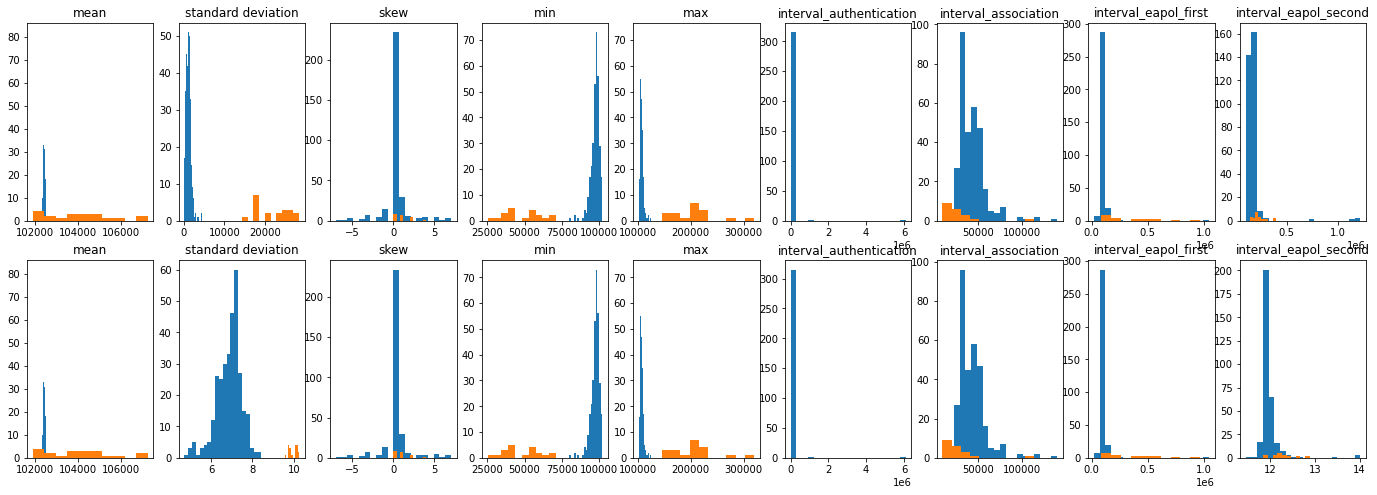

In [1634]:
features_to_trasform = [1, 8]

trans_normal_ap = transform_features(features_to_trasform, normal_ap)
trans_abnormal_ap = transform_features(features_to_trasform, abnormal_ap)

plt.figure(figsize=(24, 8))

titles = ["mean", "standard deviation", "skew", "min", "max", #beacons features
            "interval_authentication", "interval_association", "interval_eapol_first", "interval_eapol_second"] #association features
for i in range (0, n_features):
    plt.subplot(2, n_features, i + 1)
    plt.hist(normal_ap[:, i], 20)
    plt.hist(abnormal_ap[:, i])
    plt.title(titles[i])
    

for i in range(0, n_features):
    plt.subplot(2, n_features, n_features + i + 1)
    plt.hist(trans_normal_ap[:, i], 20)
    plt.hist(trans_abnormal_ap[:, i])
    plt.title(titles[i])

### Delete unused features

In [1635]:
#delete unused features
delete_features = [5]

trans_normal_ap = np.delete(trans_normal_ap, delete_features, 1)
trans_abnormal_ap = np.delete(trans_abnormal_ap, delete_features, 1)

n_features = n_features - len(delete_features)

### Build sets

Build train, validation and test sets.

**Example distribution**

train: set 60 % normal

validation set: 20 % normal, 50 % abnormal

test: set 20 % normal, 50 % abnormal

In [1636]:
def build_sets(normal_data, abnormal_data):

    #train set 60 % normal
    #validation set 20 % normal, 50 % abnormal
    #test set 20 % normal, 50 % abnormal
    total_normal_train = int(len(normal_data) * 0.60)
    total_normal_val = int(len(normal_data) * 0.20)
    total_normal_test = int(len(normal_data) * 0.20)

    total_abnormal_val = int(len(abnormal_data) * 0.50) 
    total_abnormal_test = int(len(abnormal_data) * 0.50) 

    total_train = total_normal_train
    total_val = total_normal_val + total_abnormal_val
    total_test = total_normal_test + total_abnormal_test

    #Train set
    idx = np.random.choice(len(normal_data), size=total_normal_train, replace = False)
    x_train = normal_data[idx, :]
    #remove used examples
    normal_data = np.delete(normal_data, idx, axis=0)

    #validation set
    idx = np.random.choice(len(normal_data), size=total_normal_val, replace = False)
    x_val = normal_data[idx, :]
    #remove used examples
    normal_data = np.delete(normal_data, idx, axis=0)

    idx = np.random.choice(len(abnormal_data), size=total_abnormal_val, replace = False)
    x_val = np.vstack((x_val, abnormal_data[idx, :]))
    #remove used examples
    abnormal_data = np.delete(abnormal_data, idx, axis=0)

    y_val = np.zeros((total_normal_val, 1))
    y_val = np.vstack((y_val, np.ones((total_abnormal_val, 1))))


    #Test set
    idx = np.random.choice(len(normal_data), size=total_normal_test, replace = False)
    x_test = normal_data[idx, :]

    idx = np.random.choice(len(abnormal_data), size=total_abnormal_test, replace = False)
    x_test = np.vstack((x_test, abnormal_data[idx, :]))

    y_test = np.zeros((total_normal_test, 1))
    y_test = np.vstack((y_test, np.ones((total_abnormal_test, 1))))

    return x_train, x_val, y_val, x_test, y_test

In [1637]:
x_train, x_val, y_val, x_test, y_test = build_sets(trans_normal_ap, trans_abnormal_ap)

total_train = len(x_train)
total_val = len(x_val)
total_normal_val = len(y_val[y_val == 0])
total_abnormal_val = len(y_val[y_val == 1])

total_test = len(x_test)
total_normal_test = len(y_test[y_test == 0])
total_abnormal_test = len(y_test[y_test == 1])

print(f"Training set\n Total examples: {total_train}\n")
print(f"Validation set\n Total examples: {total_val}\n Total normal: {total_normal_val}\n Total abnormal: {total_abnormal_val}")
print(f"Test set\n Total examples: {total_test}\n Total normal: {total_normal_test}\n Total abnormal: {total_abnormal_test}")


Training set
 Total examples: 190

Validation set
 Total examples: 73
 Total normal: 63
 Total abnormal: 10
Test set
 Total examples: 73
 Total normal: 63
 Total abnormal: 10


### Gaussian Distribution

To perform anomaly detection, you will first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each of the features. For each feature (i = 1 . . . n), you need to find parameters mean and variance(mu, sigma²). For doing that let’s write down the function that calculates the mean and variance of matrix Xtrain.

The Gaussian distribution is given by:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [1638]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m = X.shape[0]  #number of examples in X
    
    #compute mean 
    mu = np.mean(X, axis=0)
     
    # compute variance =sigma^2
    sigma2 = 1/m * np.sum((X - mu)**2,axis=0)
    
    return mu,sigma2

### Multivariate Gaussian Distribution

Inside *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are zero. 
Then the formula for the multivariate distribution to get the probability vector is applied.

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [1639]:
#Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n= len(mu) #number of features 
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

F1 score is used to determine the best parameters i.e best epsilon and best F1 instead of accuracy as the dataset is highly unbalanced. F1 score takes into consideration precision and recall.

Precision = true positive/(true positive + false positive)

Recall = true positive /(true positive + false negative)

F1=2(Recall * Precision) / (Recall + Precision)

Best parameters are the ones in which the F1 score value is maximum.

Predict anomaly if pval<epsilon that gives a vector of binary values in the variable predictions.

Note: We need a try-except block because there can be cases where we divide by zero to calculate precision and recall.

In [1640]:
from sklearn.metrics import confusion_matrix

#Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers
    """
    best_epi = 0
    best_F1 = 0
    best_tn = 0
    best_fp = 0
    best_fn = 0
    best_tp = 0

    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis]
        #compute true positive (TP)
        #tp = np.sum(predictions[yval==1]==1)

        #compute true negative (TN)
        #tn = np.sum(predictions[yval==0]==0)
        
        #compute false positive (FP)
        #fp = np.sum(predictions[yval==0]==1)
        
        #compute false negative 
        #fn = np.sum(predictions[yval==1]==0)      
        
        tn, fp, fn, tp = confusion_matrix(yval, predictions).ravel()
        
        try:
            # compute precision, recall and F1
            prec = tp/(tp+fp)
            
            #compute recall and F1
            rec = tp/(tp+fn)

            #compute  F1
            F1 = (2*prec*rec)/(prec+rec) 
        
            if F1 > best_F1:
                best_F1 = F1
                best_epi = epi
                best_tn = tn
                best_fp = fp
                best_fn = fn
                best_tp = tp
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1, best_tn, best_fp, best_fn, best_tp

In [1641]:

mu, sigma2 = estimateGaussian(x_train)
print(f"mu = {mu} ; sigma2 = {sigma2}")

#Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(x_val, mu, sigma2)

#Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1, tn, fp, fn, tp = selectThreshold(y_val, pval)

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")

print("Best epsilon found using cross-validation:",epsilon) 
print("Best F1 on Cross Validation Set:",F1) 


mu = [1.02399879e+05 6.86569154e+00 2.31578947e-01 9.73204474e+04
 1.07650879e+05 4.21773509e+04 1.08703350e+05 1.19596927e+01] ; sigma2 = [2.20548535e+03 3.73059780e-01 2.36742382e+00 8.63732250e+06
 9.74737234e+06 1.98562433e+08 2.98847754e+08 4.91993661e-02]
True positives: 10
False positives: 7
True negatives: 56
False negatives: 0
Best epsilon found using cross-validation: 2.1053841083022363e-23
Best F1 on Cross Validation Set: 0.7407407407407407


We need to return the indices of the outliers to identify the faulty servers. This gives us a vector with binary entries where 1 means anomaly and 0 means normal.

In [1642]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [1643]:
#Apply multivariateGaussian to detect abnormal examples (outliers) 
p = multivariateGaussian(x_test, mu, sigma2)
actual_outliers = np.where(y_test.flatten() == 1)[0]

outl = (p < epsilon)
outliers=findIndices(outl)
count_outliers = len(outliers)
print('\n\nNumber of outliers (Xtest):', count_outliers)
print('\nPredicted Outliers (Xtest):', outliers)
print("Actual outliers (Xtest):", actual_outliers)

detected_outliers = [actual_outlier for actual_outlier in actual_outliers if actual_outlier in outliers]
undetected_outliers = [actual_outlier for actual_outlier in actual_outliers if actual_outlier not in outliers]

total_samples = len(x_test)
tp = len(detected_outliers)
fp = count_outliers - len(detected_outliers)
fn = len(undetected_outliers)
tn = total_samples - tp - fp - fn

prec = tp/(tp+fp)
rec = tp/(tp+fn)

F1 = (2*prec*rec)/(prec+rec) 

print("\nTotal samples: ", total_samples)
print('True positives: ', tp)
print('False positives: ', fp)
print('True negatives: ', tn)
print('False negatives: ', fn)

print('\nF1 score: ', F1)



Number of outliers (Xtest): 27

Predicted Outliers (Xtest): [2, 4, 7, 12, 14, 15, 16, 18, 22, 25, 33, 35, 36, 39, 43, 58, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
Actual outliers (Xtest): [63 64 65 66 67 68 69 70 71 72]

Total samples:  73
True positives:  10
False positives:  17
True negatives:  46
False negatives:  0

F1 score:  0.5405405405405406
